In [1]:
%matplotlib notebook

##### https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

In [2]:
import glob
import csv
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import collections
import requests
import os
import io
import zipfile
import datetime
import time 
from datetime import datetime
import numpy as np

In [3]:
filepaths = ['../data/sales/sales_2019_data_mart.csv',
             '../data/sales/sales_2018_data_mart.csv', 
             '../data/sales/sales_2017_data_mart.csv',
            '../data/sales/sales_2016_data_mart.csv',
            '../data/sales/sales_2015_data_mart.csv',
            '../data/sales/sales_2014_data_mart.csv',
            '../data/sales/sales_2013_data_mart.csv',
            '../data/sales/sales_2012_data_mart.csv',
            '../data/sales/sales_2011_data_mart.csv',
            ]
df_read = pd.concat(map(pd.read_csv, filepaths))
df_read_dedup = df_read.drop_duplicates(subset=[i for i in df_read.columns], keep=False)
df_read_dedup['Settlement_Date_f'] = pd.to_datetime(df_read_dedup['Settlement_Date_f']) 
print(len(df_read_dedup))
print(df_read_dedup.dtypes)
df_read_dedup.head(1)

605864
Settlement_Date_f                 datetime64[ns]
Property_Locality                         object
Property_Post_Code                       float64
Property_Price_Sq_Meter_mean             float64
Property_Price_Sq_Meter_count              int64
Property_Price_Sq_Meter_min              float64
Property_Price_Sq_Meter_max              float64
Property_Price_Sq_Meter_median           float64
Property_Price_Sq_Meter_std              float64
dtype: object


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,Settlement_Date_f,Property_Locality,Property_Post_Code,Property_Price_Sq_Meter_mean,Property_Price_Sq_Meter_count,Property_Price_Sq_Meter_min,Property_Price_Sq_Meter_max,Property_Price_Sq_Meter_median,Property_Price_Sq_Meter_std
0,2010-11-01,SHELLCOVE,2529.0,210.345902,1,210.345902,210.345902,210.345902,NaN


In [8]:
df_read_dedup.columns

Index(['Settlement_Date_f', 'Property_Locality', 'Property_Post_Code',
       'Property_Price_Sq_Meter_mean', 'Property_Price_Sq_Meter_count',
       'Property_Price_Sq_Meter_min', 'Property_Price_Sq_Meter_max',
       'Property_Price_Sq_Meter_median', 'Property_Price_Sq_Meter_std'],
      dtype='object')

In [9]:
df_read_dedup['Settlement_Date_Month'] = df_read_dedup['Settlement_Date_f'].values.astype('datetime64[M]')
df_read_dedup.set_index('Settlement_Date_Month',inplace=True)
df_ts = df_read_dedup[['Property_Price_Sq_Meter_count']]
df_ts.head(2)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Property_Price_Sq_Meter_count
Settlement_Date_Month,
2010-11-01,1
2017-10-01,1


In [11]:
ts = df_ts.groupby(df_ts.index)["Property_Price_Sq_Meter_count"].mean()
ts = ts['2011-01-01':'2019-01-31']
#ts.head(10)
#ts[datetime(1911,2,1)]

In [12]:
#ts['2011-01-01':'2018-12-31']
ts['2018']

Settlement_Date_Month
2018-01-01    1.366900
2018-02-01    1.232874
2018-03-01    1.309476
2018-04-01    1.297784
2018-05-01    1.287694
2018-06-01    1.345367
2018-07-01    1.282273
2018-08-01    1.325855
2018-09-01    1.279917
2018-10-01    1.258330
2018-11-01    1.311045
2018-12-01    1.351933
Name: Property_Price_Sq_Meter_count, dtype: float64

<IPython.core.display.Javascript object>


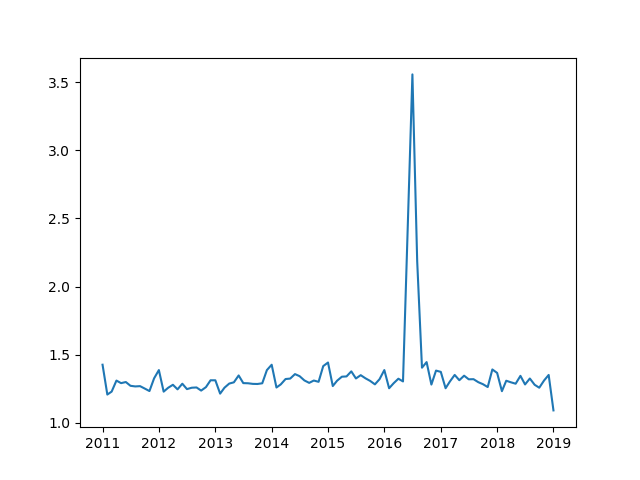

In [13]:
plt.plot(ts)


In [95]:
#rolling = ts.rolling(window=12)
#rolling.mean()

In [8]:
# rolling mean and st -  Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, rolling_window):
    plt.figure(figsize=(10,15))
    
    #Determing rolling statistics
    rolling = timeseries.rolling(window=rolling_window)
    rolmean = rolling.mean() #pd.rolling(timeseries, window=12).mean()
    rolstd = rolling.std() #pd.rolling(timeseries, window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

<IPython.core.display.Javascript object>


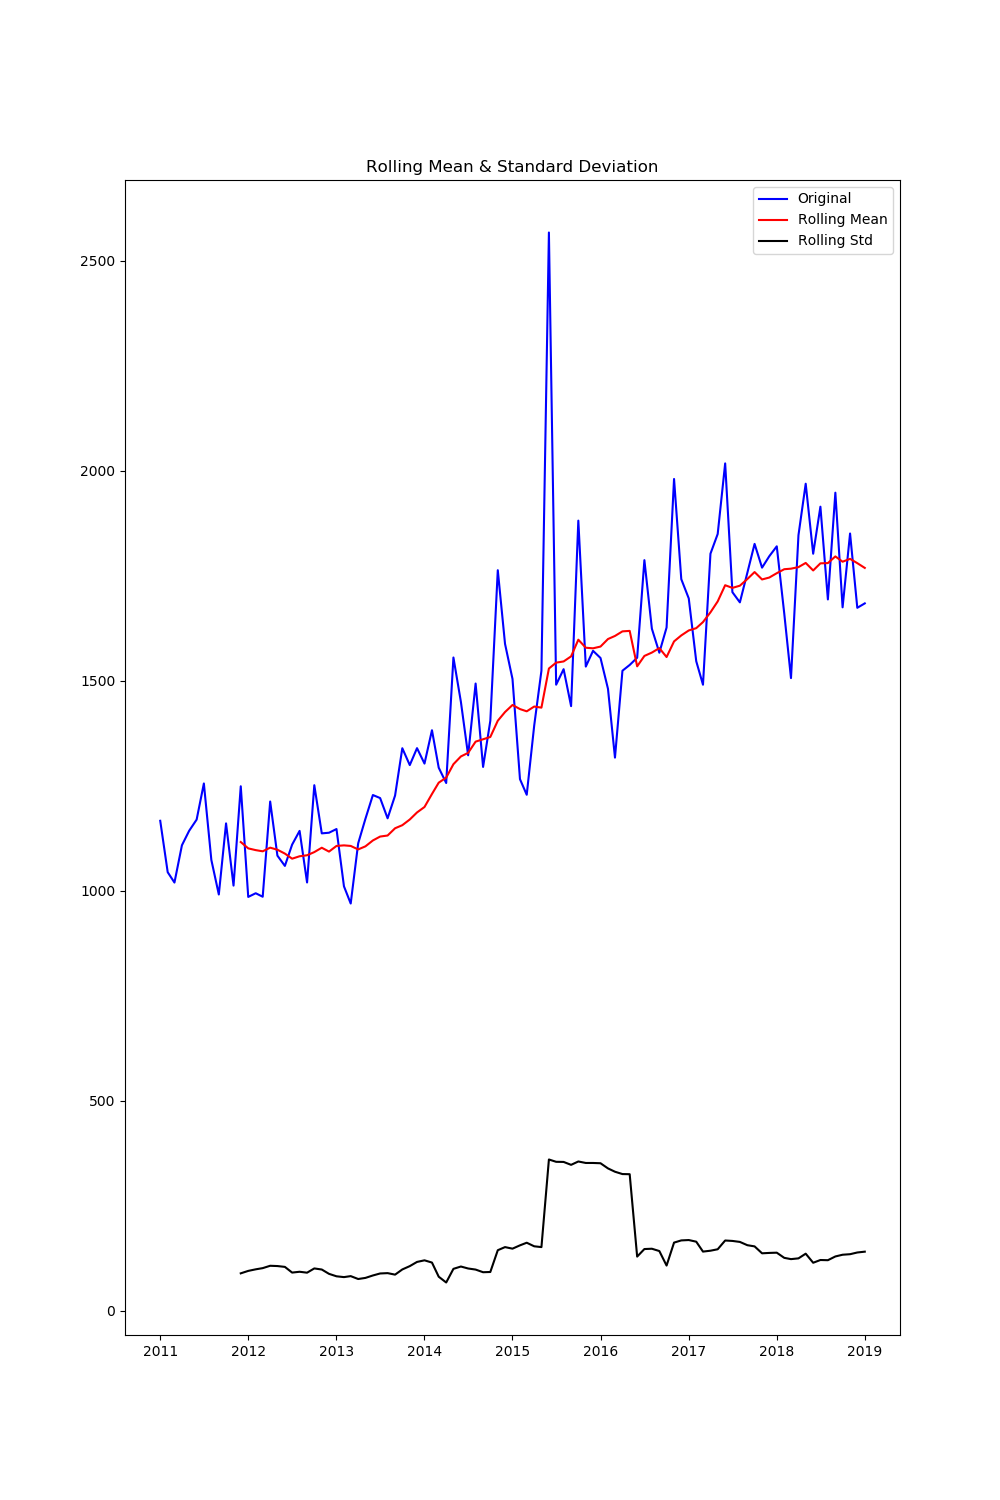

Results of Dickey-Fuller Test:
Test Statistic                 -0.612912
p-value                         0.868038
#Lags Used                     12.000000
Number of Observations Used    84.000000
Critical Value (1%)            -3.510712
Critical Value (5%)            -2.896616
Critical Value (10%)           -2.585482
dtype: float64


In [9]:
test_stationarity(ts, 12)

## Estimating & Eliminating Trend


<IPython.core.display.Javascript object>


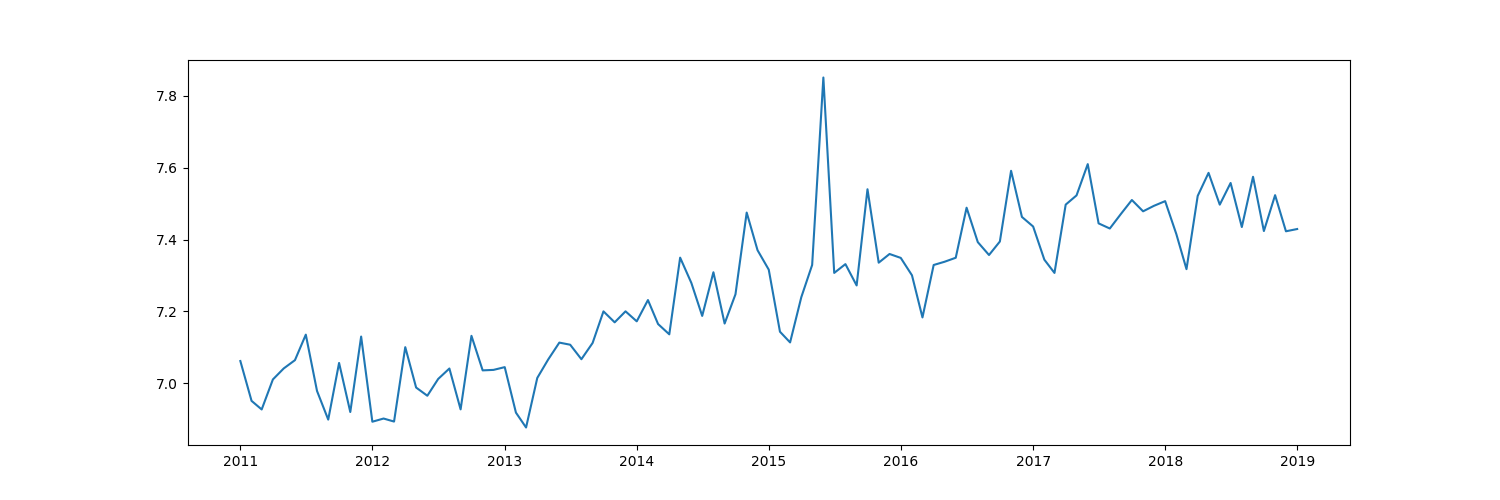

In [10]:
ts_log = np.log(ts)
plt.figure(figsize=(15,5))
plt.plot(ts_log)
plt.show()

## Moving Average

<IPython.core.display.Javascript object>


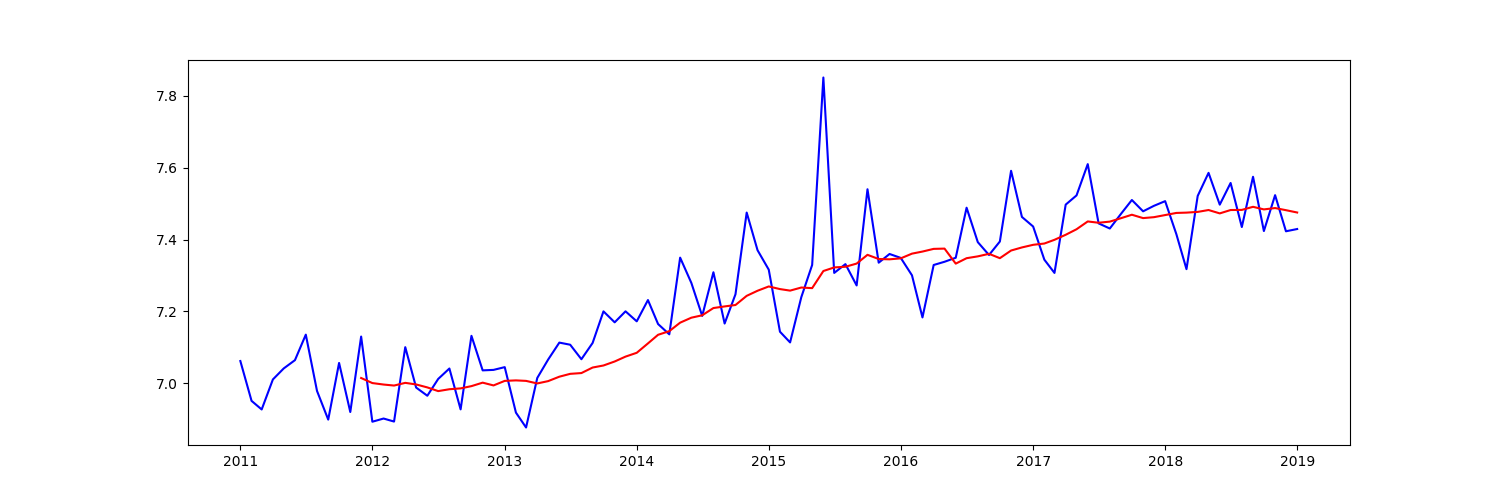

In [12]:
rolling = ts_log.rolling(window=12)
moving_avg =rolling.mean()
plt.figure(figsize=(15,5))
plt.plot(ts_log, color="blue")
plt.plot(moving_avg, color='red')
plt.show()

In [108]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Settlement_Date_Month
2011-01-01         NaN
2011-02-01         NaN
2011-03-01         NaN
2011-04-01         NaN
2011-05-01         NaN
2011-06-01         NaN
2011-07-01         NaN
2011-08-01         NaN
2011-09-01         NaN
2011-10-01         NaN
2011-11-01         NaN
2011-12-01    0.115296
Name: Property_Price_Sq_Meter_median, dtype: float64

In [13]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff,12)

NameError: name 'ts_log_moving_avg_diff' is not defined

## Weighted Moving Average

<IPython.core.display.Javascript object>


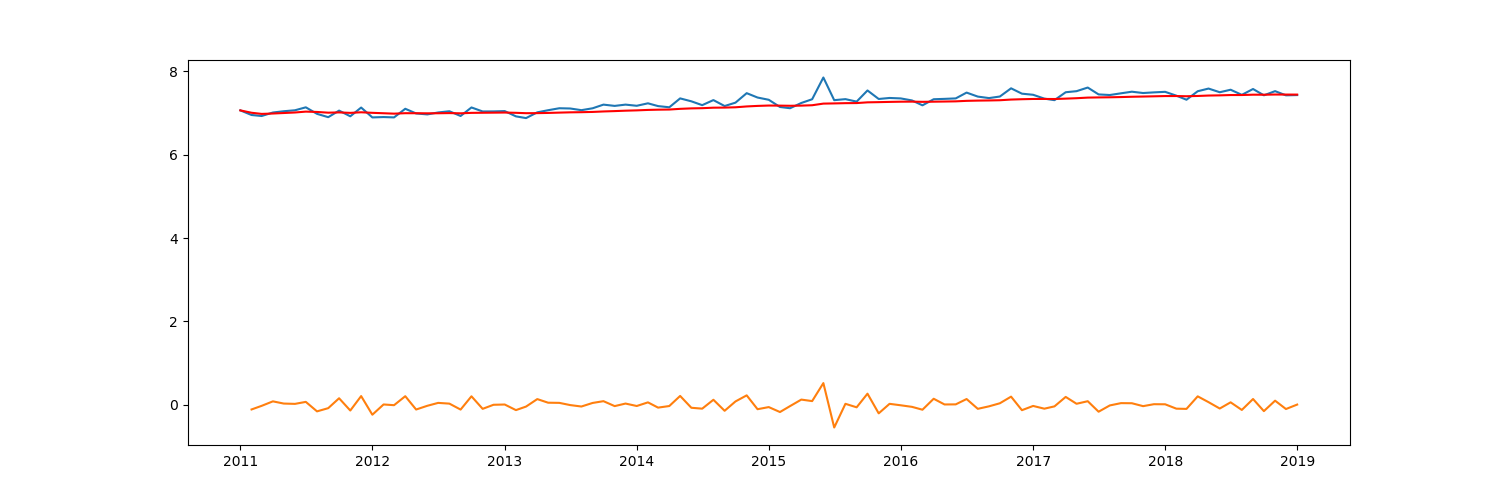

In [14]:
#expwighted_avg = pd.ewma(ts_log, halflife=12)
expwighted_avg = ts_log.ewm(halflife=12).mean()

plt.figure(figsize=(15,5))
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')
plt.show()

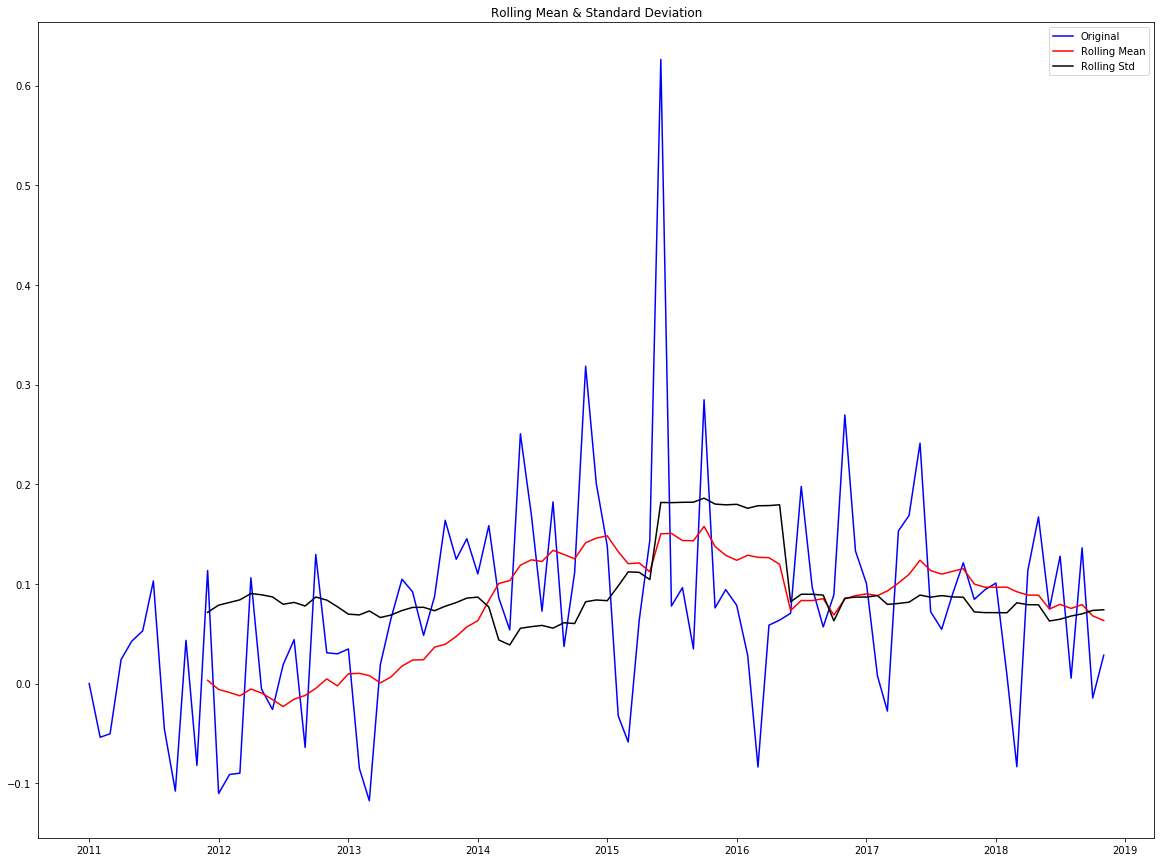

Results of Dickey-Fuller Test:
Test Statistic                -7.094439e+00
p-value                        4.325827e-10
#Lags Used                     0.000000e+00
Number of Observations Used    9.400000e+01
Critical Value (1%)           -3.501912e+00
Critical Value (5%)           -2.892815e+00
Critical Value (10%)          -2.583454e+00
dtype: float64


In [117]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff,12)

## Eliminating Trend and Seasonality


### Differencing

In [15]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
plt.show()

<IPython.core.display.Javascript object>


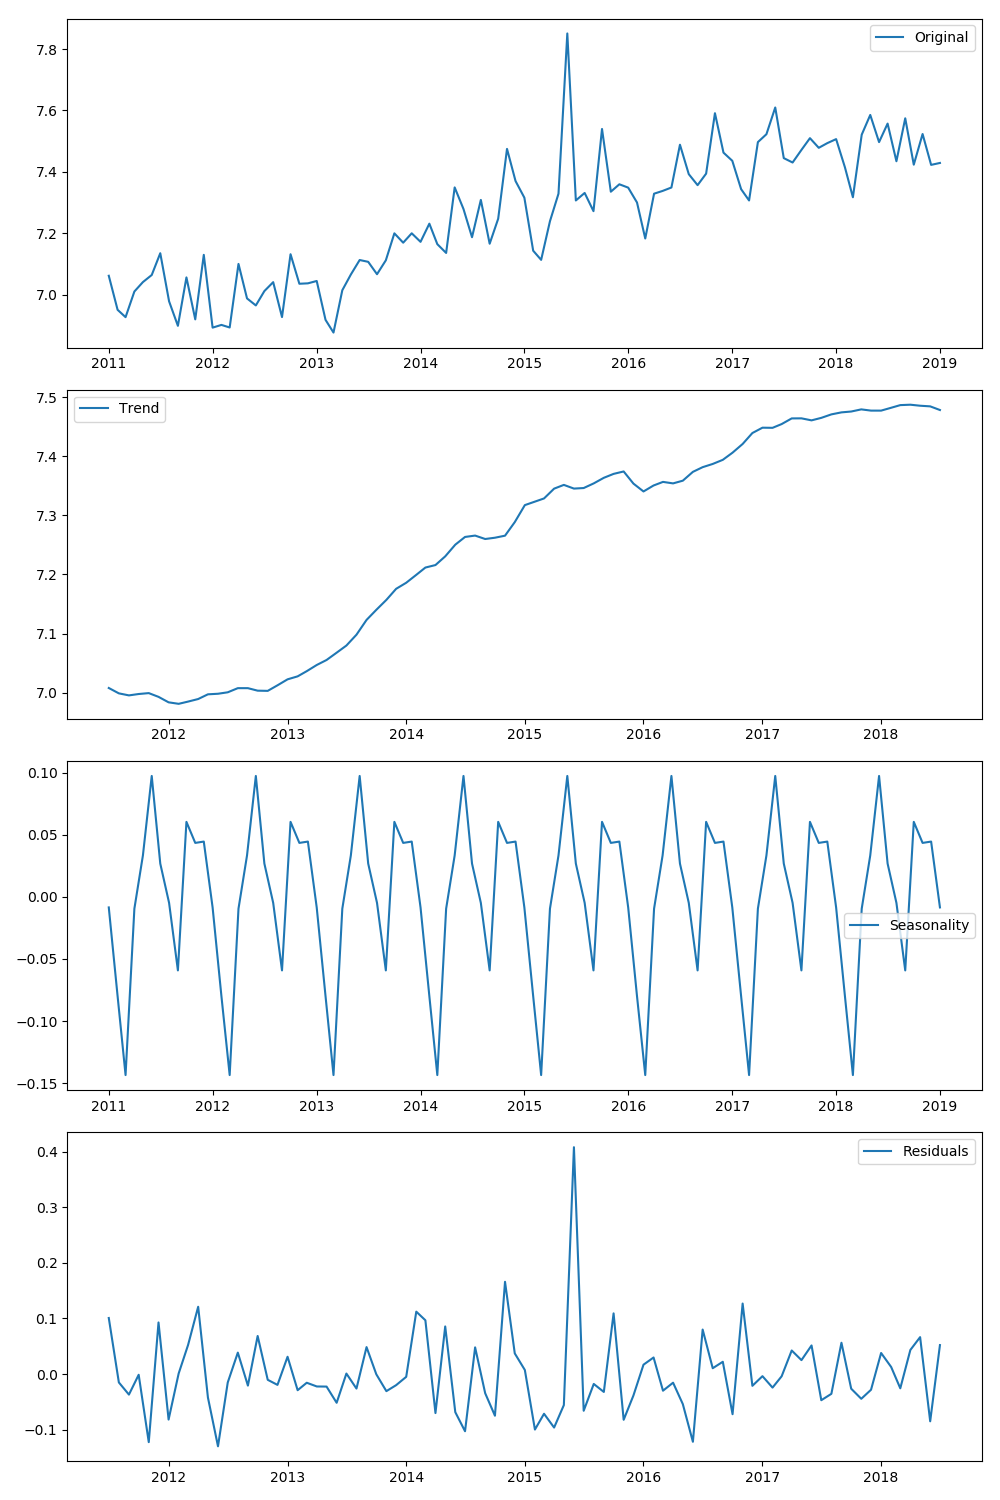

Results of Dickey-Fuller Test:
Test Statistic                 -3.805002
p-value                         0.002857
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [16]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff,12)


### Decomposing

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

<IPython.core.display.Javascript object>


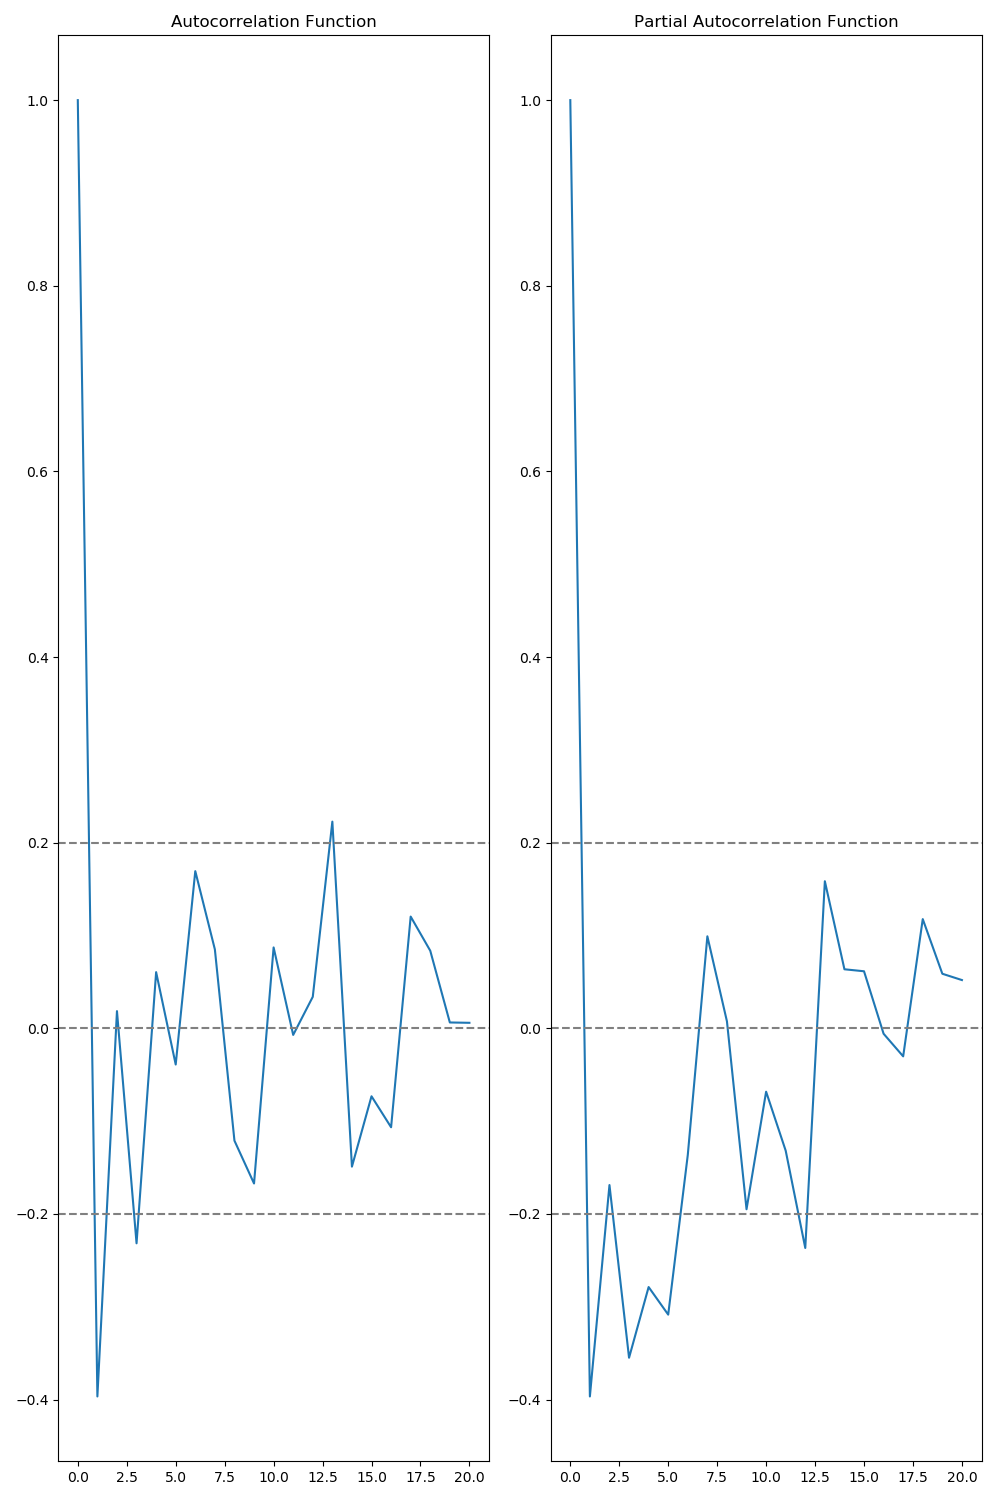

Results of Dickey-Fuller Test:
Test Statistic                 -4.377467
p-value                         0.000325
#Lags Used                     11.000000
Number of Observations Used    73.000000
Critical Value (1%)            -3.523284
Critical Value (5%)            -2.902031
Critical Value (10%)           -2.588371
dtype: float64


In [18]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose,12)

## Forecasting a Time Series

In [19]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [20]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

In [21]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

Text(0.5,1,'Autocorrelation Function')

In [22]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [23]:
from statsmodels.tsa.arima_model import ARIMA


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<IPython.core.display.Javascript object>


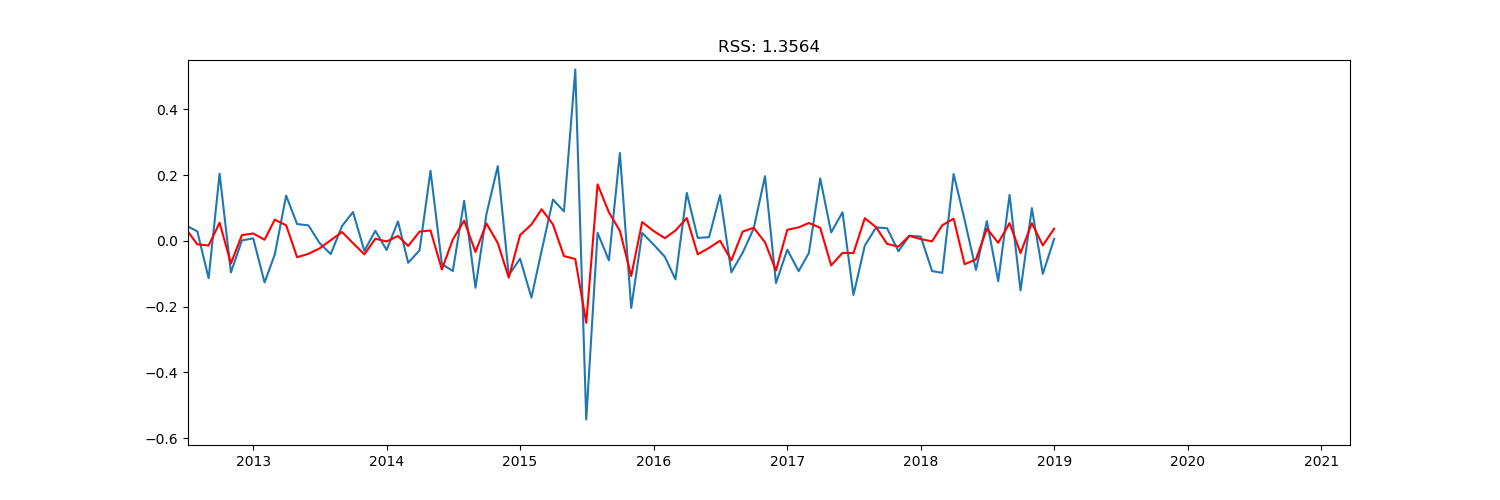

In [24]:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  

plt.figure(figsize=(15,5))
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))
plt.show()

## MA Model


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<IPython.core.display.Javascript object>


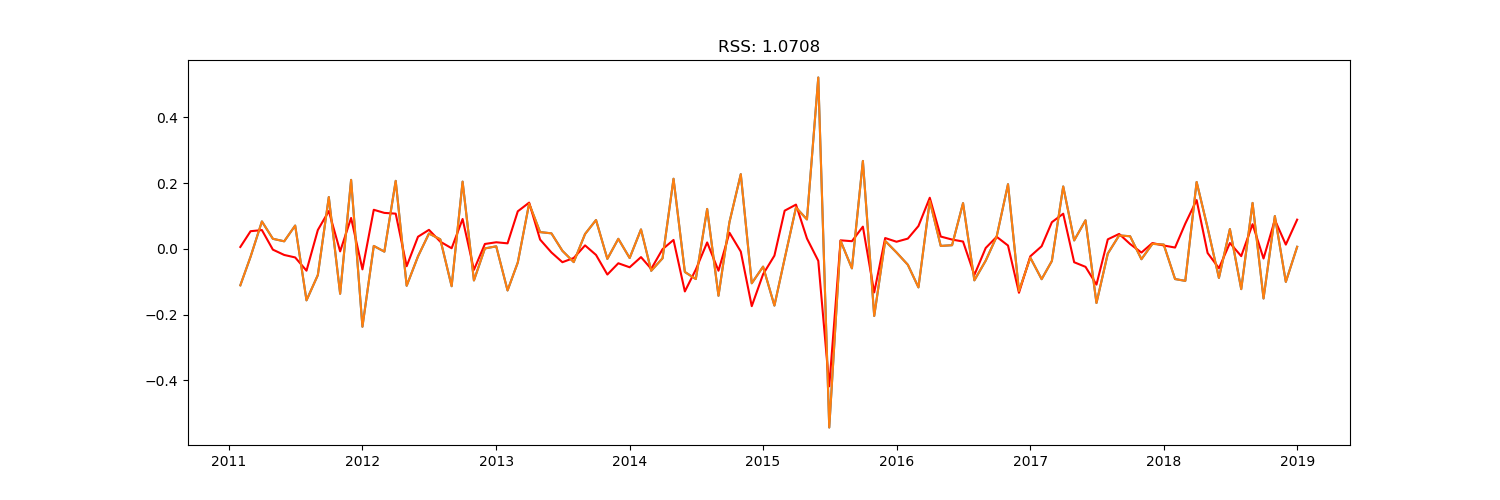

Text(0.5,1,'RSS: 1.0708')

In [25]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.figure(figsize=(15,5))
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

### Combined Model


In [26]:
model = ARIMA(ts_log, order=(2, 1, 2))  

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [27]:
try:
    results_ARIMA = model.fit(disp=-1)  
except:
    pass

In [28]:

plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

NameError: name 'results_ARIMA' is not defined